# Initialization

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm
import seaborn as sns
import pickle
import scipy.stats as stats

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization, Concatenate

# you can either allocate a fixed amount of memory or set_memory_growth by commenting the appropriate "if" statement
GPU_MEMORY = 6140

gpus = tf.config.list_physical_devices('GPU')

"""
to allocate a fixed amount of memory
"""
if gpus:
  # restrict TensorFlow to only allocate GPU_MEMORY on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=GPU_MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # rirtual devices must be set before GPUs have been initialized
    print(e)

"""
for the dynamic Tensorflow allocation
"""
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# checks that the GPU is detected
if len(tf.config.list_physical_devices('GPU'))==0:
    print("\n No GPU detected! \n")
else:
    print("\n Tensorflow running with GPU!")
    print(tf.config.list_physical_devices('GPU'), "\n")

In [4]:
start_date = pd.to_datetime('2010-01-01') # considers data with date >= start_date
validation_date = pd.to_datetime('2020-01-01') # train data (start_date<=date<validation_date) & Validation data (validation_date<=date<split_date)
split_date = pd.to_datetime('2022-01-01') # test data (date>=split_date)

DATA_DIRECTORY = 'your/data/directory' # where you store data
MODELS_DIRECTORY = 'your/models/directory' # where you store models and histories

# the time frequecy used to create the matrices with "dataprep.ipynb"
# DATA_AGG = 'WEEKLY'
DATA_AGG = 'DAILY'

# comes from previous iterations of the notebook, should be removed soon
OBJECTIVE = 'OPTIMIZATION'

# the model optimizes portfolio composed of the top-N marketcap US equities
N = 500

# should be the same of the ones chosen in "dataprep.ipynb" for the matrix creation
LAG_history = 30 # time series history for features
LAG_history_fin = 8 # time series history for features_fin
N_futures = 10 # time series future history for features_fin

if DATA_AGG == 'WEEKLY':
    df_date = 'first_day_of_the_week'
elif DATA_AGG == 'DAILY':
    df_date = 'date'

In [5]:
"""
select which features to use:
    - features come from data with daily (or weekly) frequency [equity_prices, insiders]
    - features_fin come from data with quarterly frequency [financials]
    - target_val will define the feature contained in the y matrix
should be the same of the ones chosen in "dataprep.ipynb" for the matrix creation
"""
features_in_X = ['log_return_beta_adj','marketcap_ratio']
features_in_X_fin = ['change_in_fcfe','change_in_revenue','change_in_ncfo','sign_fcfe']
target_in_y = ['log_return']

In [6]:
if OBJECTIVE == 'OPTIMIZATION':
       directory = f"{DATA_DIRECTORY}/LSTM MATRICES/{DATA_AGG}/{OBJECTIVE}/LAG HISTORY {LAG_history} & LAG FIN {LAG_history_fin} & N FUTURES {N_futures}/FEATURES_{features_in_X}+{features_in_X_fin} - TARGET_{target_in_y}/TOP-{N} MARKETCAP"

os.chdir(f'{DATA_DIRECTORY}/LSTM MATRICES/{DATA_AGG}')
sp500 = pd.read_csv(f'S&P500_index_return_{DATA_AGG}.csv', parse_dates=[df_date], dtype={'index_log_return': 'float32', 'index_log_return_fut1': 'float32'})
sp500['month'] = sp500[df_date].dt.month
sp500['year'] = sp500[df_date].dt.year

os.chdir(directory)

# load matrices and dataframe in float32
X = np.load(f'TOP-{N}_matrix_X_{DATA_AGG}.npy')
X_fin = np.load(f'TOP-{N}_matrix_X_fin_{DATA_AGG}.npy')
y = np.load(f'TOP-{N}_matrix_y_{DATA_AGG}.npy')
support = pd.read_csv(f'TOP-{N}_support_{DATA_AGG}.csv', parse_dates=[df_date],
                            usecols=['log_return_beta_adj', 'index_log_return', 'marketcap', 'marketcap_rank', 'log_return_fut1', 'log_return_beta_adj_fut1'
                                     'index_log_return_fut1', 'ticker', 'bonds_yearly_rate', 'marketcap_updated', 'marketcap_ratio', df_date],
                            dtype={'log_return_beta_adj': 'float32', 'index_log_return': 'float32', 'log_return_fut1': 'float32',
                                   'marketcap_updated': 'float32', 'marketcap': 'float32', 'marketcap_rank': 'int', 'index_log_return_fut1': 'float32',
                                   'bonds_yearly_rate': 'float32', 'marketcap_ratio': 'float32', 'log_return_beta_adj_fut1': 'float32'})
print('Loaded data!')

# Add months and years
support['month'] = support[df_date].dt.month
support['year'] = support[df_date].dt.year

# create artificial S&P 500 (i.e. an index in which we select the top500 equities and allocation \propto marketcap)
ind_mcr = features_in_X.index('marketcap_ratio')
marketcapratio = np.repeat(X[:,0,ind_mcr::len(features_in_X)][:,np.newaxis,:], repeats=N_futures, axis=1)
y = np.concatenate([y, marketcapratio], axis=2) # First len(target_in_y)*N are the original features, the remaining N are the marketcap_ratio
support['artificial_sp500'] = support['log_return_fut1'] * support['marketcap_ratio']

if OBJECTIVE == 'OPTIMIZATION':
       train_index = support[df_date].unique() < split_date
       test_index = support[df_date].unique() >= split_date

       X_train = X[train_index]
       X_train_fin = X_fin[train_index]
       y_train = y[train_index]
       train_support = support.loc[support[df_date] < split_date, :].reset_index(drop=True)

       X_test = X[test_index]
       X_test_fin = X_fin[test_index]
       y_test = y[test_index]
       test_support = support.loc[support[df_date] >= split_date, :].reset_index(drop=True)

print('Splitted data!')

# del X, y, support

Loaded data!
Created log_return_beta_adj_fut1!
Splitted data!


# Assets' correlation

Can be used to compare the assets' correlation when using log_returns and β-adjusted log_returns

A sample of 50 assets is used for visualization purposes 

In [41]:
support['log_return'] = support['log_return_beta_adj'] + support['index_log_return']

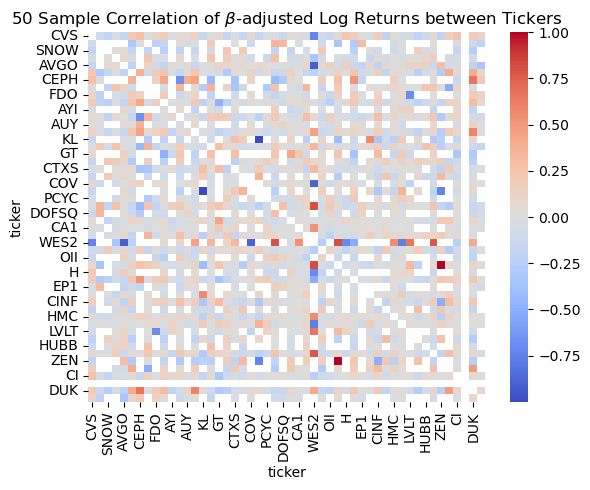

In [55]:
pivot_df = support[support.marketcap_rank <= 500].pivot_table(index='date', columns='ticker', values='log_return_beta_adj')

correlation_df = pivot_df.corr() # Correlation matrix
autocorr_mask = pd.DataFrame(np.identity(correlation_df.shape[0]), index=correlation_df.index, columns=correlation_df.columns)
correlation_df = correlation_df.mask(autocorr_mask.astype(bool))

# Sample size for plotting (e.g., 10x10)
sample_size = 50
# Get a sample of tickers (random or from a specific selection)
sampled_tickers = correlation_df.columns.to_series().sample(sample_size, random_state=42)
# Extract the sampled subset of the correlation matrix
sampled_correlation_df = correlation_df.loc[sampled_tickers, sampled_tickers]

# sns.heatmap(correlation_df, cmap='coolwarm', fmt=".2f", annot=False)
# plt.title(r'Correlation of $\beta$-adjusted Log Returns between Tickers')

sns.heatmap(sampled_correlation_df, cmap='coolwarm', fmt=".2f", annot=False)
plt.title(fr'{sample_size} Sample Correlation of $\beta$-adjusted Log Returns between Tickers')

# plt.savefig('beta_corr_500samples.png', format='png', dpi=200)
# plt.savefig('correlation_50samples_beta.png', format='png', dpi=700, transparent=True)

plt.show()

# Custom loss & activation

**An in-depth description of the model can be found in the thesis linked in the README file!**

In [7]:
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.utils import get_registered_object, get_registered_name

The utility function that we aim at maximizing:

\begin{align*}
U = w^T r - \frac{\lambda}{2}\,\sqrt{w^T\Sigma w} - p^* \left[1-\frac{w \cdot w_{sp500}}{\|w\|_2\|w_{sp500}\|_2} \right] - c \|w - w_{sp500}\|_1
\end{align*}

In [8]:
@register_keras_serializable(package='sp500_perturbator', name='SP500Perturbator_model')
class SP500Perturbator(keras.Model):
    # initialize the elements of the model
    def __init__(self, num_layers_eq, num_layers_fin, units_vector_eq, units_vector_fin, dense_units, penalty_coeff=0.01, use_transaction_costs=False,
                 transaction_coeff=1e-4, N_asset=500, dropout_rate=0.2, batch_normalization=False, name='sp500_perturbator', *args, **kwargs):
        super().__init__(name=name, *args, **kwargs)

        self.N_asset = N_asset
        self.penalty_coeff = penalty_coeff
        self.use_transaction_costs = use_transaction_costs
        self.transaction_coeff = transaction_coeff

        if num_layers_eq > 0:
            self.num_layers_eq = num_layers_eq
        else:
            raise ValueError('There must be at least one layer for log returns and marketcap ratio!')
        self.num_layers_fin = num_layers_fin
        self.units_vector_eq = units_vector_eq
        self.units_vector_fin = units_vector_fin
        self.dense_units = dense_units
        self.dropout_rate = dropout_rate
        self.batch_normalization = batch_normalization

        self.lstm_layers_eq = []
        self.dropout_layers_eq = []
        self.batchnorm_layers_eq = []

        self.lstm_layers_fin = []
        self.dropout_layers_fin = []
        self.batchnorm_layers_fin = []

        for i in range(num_layers_eq):
            if i > 0:
                self.dropout_layers_eq.append(Dropout(rate=dropout_rate, name=f'dropout_eq_{i-1}'))
                if self.batch_normalization:
                    self.batchnorm_layers_eq.append(BatchNormalization(name=f'batchnorm_eq_{i-1}'))
            self.lstm_layers_eq.append(LSTM(units=units_vector_eq[i], activation='tanh', return_sequences=(i < num_layers_eq - 1), name=f'lstm_equity_{i}'))

        for i in range(num_layers_fin):
            if i > 0:
                self.dropout_layers_fin.append(Dropout(rate=dropout_rate, name=f'dropout_fin_{i-1}'))
                if self.batch_normalization:
                    self.batchnorm_layers_fin.append(BatchNormalization(name=f'batchnorm_fin_{i-1}'))
            self.lstm_layers_fin.append(LSTM(units=units_vector_fin[i], activation='tanh', return_sequences=(i < num_layers_fin - 1), name=f'lstm_financials_{i}'))

        self.concatenate = Concatenate(axis=1, name='concatenate')
        self.dense_relu = Dense(units=dense_units, activation='relu', name='relu_dense')
        self.dense_out = Dense(units=N_asset, activation='tanh', name='final_output')

    # defines how each input is handled and the whole model architecture
    def call(self, inputs, training=False):
        equity_input, financials_input, lambdas_input, previous_allocation = inputs
        x_eq = equity_input
        x_fin = financials_input

        for i in range(self.num_layers_eq):
            if i > 0:
                x_eq = self.dropout_layers_eq[i-1](x_eq, training=training)
                if self.batch_normalization:
                    x_eq = self.batchnorm_layers_eq[i-1](x_eq, training=training)
            x_eq = self.lstm_layers_eq[i](x_eq, training=training)

        for i in range(self.num_layers_fin):
            if i > 0:
                x_fin = self.dropout_layers_fin[i-1](x_fin, training=training)
                if self.batch_normalization:
                    x_fin = self.batchnorm_layers_fin[i-1](x_fin, training=training)
            x_fin = self.lstm_layers_fin[i](x_fin, training=training)

        if self.num_layers_fin > 0:
            if self.use_transaction_costs:
                pipeline_output = [x_eq,x_fin,lambdas_input,previous_allocation]
            else:
                pipeline_output = [x_eq,x_fin,lambdas_input]
        else:
            if self.use_transaction_costs:
                pipeline_output = [x_eq,lambdas_input,previous_allocation]
            else:
                pipeline_output = [x_eq,lambdas_input]

        x = self.concatenate(pipeline_output) # Column concatenation
        x = self.dense_relu(x) # Nonlinear something
        return self.dense_out(x)
    
    """
    custom loss inspired from MPT, it also contains the normalization of weights
    in-depth description of the 4 elements of the loss is found in the thesis 
    linked in the README file
    """
    def mvu_loss_w_penalty(self, y_true, y_pred, lambdas, previous_allocation):
        # y_true: (batch_size, N_futures, 2*N)
        # lambdas : (batch_size, 1)
        # Unpack y_true
        y_returns, y_weights = y_true[:, :, :self.N_asset], y_true[:, 0, self.N_asset:] # (batch_size, N_futures, N) & (batch_size,)
        lambdas = tf.squeeze(lambdas, axis=1) # (batch_size,)
        # y_pred: (batch_size, N)

        # Perturb weights and normalize (with tanh activation, implementing tanh_softmax in the loss)
        perturbed_weights = tf.divide(y_pred, tf.reduce_sum(tf.abs(y_pred), axis=-1, keepdims=True))

        # Compute cosine distance
        norm_y_weights = tf.nn.l2_normalize(y_weights, axis=-1) # (batch_size,)
        norm_pert_weights = tf.nn.l2_normalize(perturbed_weights, axis=-1) # (batch_size,)
        cosine_similarity = tf.reduce_sum(tf.multiply(norm_y_weights, norm_pert_weights), axis=-1) # (batch_size,)
        cosine_distance = tf.subtract(1.0, cosine_similarity) # (batch_size,)
        # tf.print('pen=',tf.reduce_mean(cosine_distance))
        penalty_vector = tf.multiply(cosine_distance, self.penalty_coeff) # (batch_size,)

        # Compute portfolio returns and variance
        portfolio_returns = tf.reduce_sum(tf.multiply(y_returns, tf.expand_dims(perturbed_weights, axis=1)), axis=2) # (batch_size, N_futures)
        portfolio_returns = tf.reduce_sum(portfolio_returns, axis=1) # (batch_size,)

        # Compute batch covariance matrices (vectorized)
        y_returns_centered = y_returns - tf.reduce_mean(y_returns, axis=1, keepdims=True)  # (batch_size, N_futures, N)
        batch_covariances = tf.einsum('bij,bik->bjk', y_returns_centered, y_returns_centered) / tf.cast(tf.shape(y_returns)[1] - 1, tf.float32)  # (batch_size, N, N)

        # Compute portfolio variance with vectorized matrix multiplications
        portfolio_variance = tf.einsum('bi,bij,bj->b', perturbed_weights, batch_covariances, perturbed_weights)  # (batch_size,)
        portfolio_std = tf.sqrt(portfolio_variance)  # (batch_size,)

        # Calculate loss
        risk = tf.multiply((lambdas*0.5), portfolio_std) # (batch_size,)
        loss = tf.subtract(risk, portfolio_returns) # (batch_size,)
        loss = tf.add(loss, penalty_vector) # (batch_size,)

        # Add transaction costs
        if self.use_transaction_costs:
            allocation_difference = tf.abs(tf.subtract(perturbed_weights, previous_allocation)) # (batch_size, N)
            allocation_difference = tf.reduce_sum(allocation_difference, axis=1) # (batch_size,)
            transaction_cost = tf.multiply(allocation_difference, self.transaction_coeff)
            loss = tf.add(loss, transaction_cost)

        return tf.reduce_mean(loss) # Scalar -returns + \lambda * risk + penalty

    # tells the model how to calculate the loss, then computes the gradients and updates the model parameters 
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        (X, y) = data
        x_eq, x_fin, lambdas, prev_allocation = X

        with tf.GradientTape() as tape:
            y_pred = self(X, training=True)  # Forward pass
            # Compute the loss value
            loss = self.mvu_loss_w_penalty(y, y_pred, lambdas, prev_allocation)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
    # tells the model how to compute the validation loss
    def test_step(self, data):
        (X, y) = data
        x_eq, x_fin, lambdas, prev_allocation = X  # Unpack the input list

        y_pred = self(X, training=False)
        loss = self.mvu_loss_w_penalty(y, y_pred, lambdas, prev_allocation) 

        # Update and return loss and other metrics
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred)
        metrics = {m.name: m.result() for m in self.metrics}
        return metrics
    
    # builds the model with the appropriate shapes
    def build(self, input_shape):
        # Call build on all layers with their expected input shapes.
        # You can derive these input shapes from input_shape if necessary.
        for i in range(self.num_layers_eq):
            if i == 0:
                layers_input_shape_eq = input_shape[0]
            elif i > 0:
                self.dropout_layers_eq[i-1].build(lstm_output_shape_eq)
                layers_input_shape_eq = self.dropout_layers_eq[i-1].compute_output_shape(lstm_output_shape_eq)
                if self.batch_normalization:
                    self.batchnorm_layers_eq[i-1].build(layers_input_shape_eq)
                    layers_input_shape_eq = self.batchnorm_layers_eq[i-1].compute_output_shape(layers_input_shape_eq)
            self.lstm_layers_eq[i].build(layers_input_shape_eq)
            lstm_output_shape_eq = self.lstm_layers_eq[i].compute_output_shape(layers_input_shape_eq)

        for i in range(self.num_layers_fin):
            if i == 0:
                layers_input_shape_fin = input_shape[1]
            elif i > 0:
                self.dropout_layers_fin[i-1].build(lstm_output_shape_fin)
                layers_input_shape_fin = self.dropout_layers_fin[i-1].compute_output_shape(lstm_output_shape_fin)
                if self.batch_normalization:
                    self.batchnorm_layers_fin[i-1].build(layers_input_shape_fin)
                    layers_input_shape_fin = self.batchnorm_layers_fin[i-1].compute_output_shape(layers_input_shape_fin)
            self.lstm_layers_fin[i].build(layers_input_shape_fin)
            lstm_output_shape_fin = self.lstm_layers_fin[i].compute_output_shape(layers_input_shape_fin)

        if self.num_layers_fin > 0:
            if self.use_transaction_costs:
                pipeline_output = [lstm_output_shape_eq, lstm_output_shape_fin, input_shape[2], input_shape[3]]
            else:
                pipeline_output = [lstm_output_shape_eq, lstm_output_shape_fin, input_shape[2]]
        else:
            if self.use_transaction_costs:
                pipeline_output = [lstm_output_shape_eq, input_shape[2], input_shape[3]]
            else:
                pipeline_output = [lstm_output_shape_eq, input_shape[2]]

        # Building additional layers:
        self.concatenate.build(pipeline_output)
        self.dense_relu.build(self.concatenate.compute_output_shape(pipeline_output))
        self.dense_out.build(self.dense_relu.compute_output_shape(self.concatenate.compute_output_shape(pipeline_output)))
        
        # Mark model as built
        super().build(input_shape)

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_layers_eq': self.num_layers_eq,
            'num_layers_fin': self.num_layers_fin,
            'units_vector_eq': self.units_vector_eq,
            'units_vector_fin': self.units_vector_fin,
            'dense_units': self.dense_units,
            'penalty_coeff': self.penalty_coeff,
            'use_transaction_costs': self.use_transaction_costs,
            'transaction_coeff': self.transaction_coeff,
            'N_asset': self.N_asset,
            'dropout_rate': self.dropout_rate,
            'batch_normalization': self.batch_normalization,
            'name': self.name,
            'mvu_loss_w_penalty': self.mvu_loss_w_penalty,
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        # Extract custom loss function from config
        mvu_loss_w_penalty = config.pop('mvu_loss_w_penalty', None)
        model = cls(**config)
        model.mvu_loss_w_penalty = mvu_loss_w_penalty
        return model

# ensures the custom model is correctly serialized
assert get_registered_object('sp500_perturbator>SP500Perturbator_model') == SP500Perturbator
assert get_registered_name(SP500Perturbator) == 'sp500_perturbator>SP500Perturbator_model'

# Training with validation

In [9]:
assert (np.sort(train_support[df_date].unique()) == train_support[df_date].unique()).all()

In [10]:
# creates indices
if OBJECTIVE == 'OPTIMIZATION':
    train_index = (train_support[df_date].unique() < validation_date) & (train_support[df_date].unique() >= start_date)
    validation_index = (train_support[df_date].unique() >= validation_date) & (train_support[df_date].unique() >= start_date)
    test_index = np.full(len(X_test), True)

    train_index_df = (train_support[df_date] >= start_date) & (train_support[df_date] < validation_date)
    validation_index_df = (train_support[df_date] >= start_date) & (train_support[df_date] >= validation_date)

In [11]:
"""
defines hyperparameters of the model
"""
num_layers_eq = 1
num_layers_fin = 2

units_1 = 2
units_eq = [units_1]

units_1_fin = 1
units_2_fin = 2
units_fin = [units_1_fin, units_2_fin]

dense_units = 8

batch_size = 64 

epochs = 1000

learning_rate = 2e-5

batch_normalization = False

dropout_rate = 0.4

risk_aversion = 1.0

penalty_coeff = 0.005

transaction_coeff = 1e-4

### Loading $\lambda$-s and random allocations

In [12]:
# function to create gaussian long-short allocations
def create_random_allocation(size, mean=0, std=0.1):
    random_numbers = np.random.normal(loc=mean, scale=std, size=size) # (n_samples, N)
    random_weights = random_numbers / np.sum(np.abs(random_numbers), axis=1, keepdims=True) # (n_samples, N)

    return random_weights

In [13]:
"""
creates artificial data (λ risk-aversion and previous time allocations) from training and validation
the reason is explained in the thesis linked in the README file
"""
np.random.seed(0)
n_features = len(X_train[0,0])
n_train = X_train[train_index].shape[0]
n_valid = X_train[validation_index].shape[0]

low_lambda, break_lambda, high_lambda = 0.0, 1.0, 4.0

random_numbers_1 = np.random.uniform(low=low_lambda, high=break_lambda, size=(n_train // 2))
random_numbers_2 = np.random.uniform(low=low_lambda, high=high_lambda, size=(n_train // 2 + n_train % 2))
train_random_lambdas = np.concatenate([random_numbers_1, random_numbers_2])
np.random.shuffle(train_random_lambdas)
train_random_lambdas = train_random_lambdas.reshape(-1,1)

random_numbers_1 = np.random.uniform(low=low_lambda, high=break_lambda, size=(n_valid // 2))
random_numbers_2 = np.random.uniform(low=low_lambda, high=high_lambda, size=(n_valid // 2 + n_valid % 2))
valid_random_lambdas = np.concatenate([random_numbers_1, random_numbers_2])
np.random.shuffle(valid_random_lambdas)
valid_random_lambdas = valid_random_lambdas.reshape(-1,1)

train_lambda = train_random_lambdas
valid_lambda = valid_random_lambdas
test_lambda = np.full((len(X_test), 1), risk_aversion)

train_allocation = create_random_allocation((n_train, N))
valid_allocation = create_random_allocation((n_valid, N))
test_allocation = create_random_allocation((len(X_test), N)) # Dummy to make the "no_transaction" model work

X_train_lstm = [X_train[train_index], X_train_fin[train_index], train_lambda, train_allocation]
X_valid_lstm = [X_train[validation_index], X_train_fin[validation_index], valid_lambda, valid_allocation]
# For test I'll have to use the actual previous day allocation
X_test_lstm = [X_test, X_test_fin, test_lambda, test_allocation]

### Training

#### With validation

In [159]:
# initializes the model that does NOT minimize transaction costs
no_transaction_model = SP500Perturbator(num_layers_eq=num_layers_eq, num_layers_fin=num_layers_fin, units_vector_eq=units_eq,
                                        units_vector_fin=units_fin, dense_units=dense_units, penalty_coeff=penalty_coeff)

# Define the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the optimizer and loss function
no_transaction_model.compile(optimizer=optimizer) #, loss=MVULoss_w_Penalty(multi_model.penalty_coeff))

# Define early stopping callback
early_stopping_no_trans = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True, verbose=1, start_from_epoch=5)

# Building the model
no_transaction_model.build(input_shape=[(None, LAG_history, N*len(features_in_X)), (None, LAG_history_fin, N*len(features_in_X_fin)), (None, 1), (None, N)])

In [160]:
# initializes the model that also minimizes transaction costs
transaction_model = SP500Perturbator(num_layers_eq=num_layers_eq, num_layers_fin=num_layers_fin, units_vector_eq=units_eq, units_vector_fin=units_fin,
                                     dense_units=dense_units, penalty_coeff=penalty_coeff, use_transaction_costs=True, transaction_coeff=transaction_coeff)

# Define the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the optimizer and loss function
transaction_model.compile(optimizer=optimizer) #, loss=MVULoss_w_Penalty(multi_model.penalty_coeff))

# Define early stopping callback
early_stopping_trans = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True, verbose=1, start_from_epoch=5)

# Building the model
transaction_model.build(input_shape=[(None, LAG_history, N*len(features_in_X)), (None, LAG_history_fin, N*len(features_in_X_fin)), (None, 1), (None, N)])

In [ ]:
# training of both models
history_no_trans = no_transaction_model.fit(X_train_lstm, y_train[train_index], validation_data=(X_valid_lstm, y_train[validation_index]),
                                            epochs=epochs, batch_size=batch_size, callbacks=[early_stopping_no_trans], shuffle=True)
history_trans = transaction_model.fit(X_train_lstm, y_train[train_index], validation_data=(X_valid_lstm, y_train[validation_index]),
                                        epochs=epochs, batch_size=batch_size, callbacks=[early_stopping_trans], shuffle=True)

#### Features subset selection

We evaluate if adding the financial features improves the performances of the model

##### K-Fold Cross Validation

We run two k-fold cross validations:
- 3-fold CV among all the 16 configurations (we consider 4 features) to select the best performing one;
- 30-fold CV among the best one and the simplest one (with none of the features) in order to check if better results are obtained and are statistically significant

###### 3-fold

In [14]:
from sklearn.model_selection import KFold

In [ ]:
# each array will tell which of the 4 financial features to consider (e.g. [0] will only keep "change_in_fcfe")
possible_combinations = [[0],[1],[2],[3],[0,1],[0,2],[0,3],[1,2],[1,3],[2,3],[0,1,2],[0,1,3],[0,2,3],[1,2,3],[0,1,2,3], None]
k = 3  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=15)

global_val_losses = []

for selected_features in tqdm(possible_combinations):
    # Initialize mask
    mask = np.zeros(N*len(features_in_X_fin), dtype=bool)
    # Set True for selected features
    if selected_features == None:
        num_layers_fin_for_loop = 0
    else:
        num_layers_fin_for_loop = num_layers_fin
        for asset_idx in range(N):
            for feature in selected_features:
                mask[asset_idx * len(features_in_X_fin) + feature] = True

    print('\nCV for selected features = ',selected_features)

    X_for_cv = X_train[train_index+validation_index]
    X_fin_for_cv = X_train_fin[train_index+validation_index][:,:,mask]
    lambda_for_cv = np.concatenate([train_lambda,valid_lambda], axis=0)
    y_for_cv = y_train[train_index+validation_index]

    # Step 4: Train and validate the model for each fold
    fold_no = 1
    val_losses_cv = []

    for train_index_cv, val_index_cv in kf.split(X_for_cv):
        # Split data
        X_train_lstm_cv = [X_for_cv[train_index_cv], X_fin_for_cv[train_index_cv], lambda_for_cv[train_index_cv]]
        X_val_lstm_cv = [X_for_cv[val_index_cv], X_fin_for_cv[val_index_cv], lambda_for_cv[val_index_cv]]
        y_train_cv = y_train[train_index_cv]
        y_val_cv = y_train[val_index_cv]
        
        # Create a new instance of the model
        model = SP500Perturbator(num_layers_eq=num_layers_eq, num_layers_fin=num_layers_fin_for_loop, units_vector_eq=units_eq,
                                units_vector_fin=units_fin, dense_units=dense_units, penalty_coeff=penalty_coeff)
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer)
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True, verbose=1, start_from_epoch=5)
        model.build(input_shape=[(None, LAG_history, N*len(features_in_X)), (None, LAG_history_fin, N*X_train_fin[:,:,mask].shape[2]), (None, 1)])

        history = model.fit(X_train_lstm_cv, y_train_cv, validation_data=(X_val_lstm_cv, y_val_cv),
                            epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], shuffle=True, verbose=0)
        
        # Get the validation loss for the current fold
        val_loss = min(history.history['val_loss'])
        val_losses_cv.append(val_loss)
        
        print(f'Fold {fold_no} - Best Validation Loss: {val_loss}')
        fold_no += 1

    # Step 5: Evaluate the results
    average_val_loss = np.mean(val_losses_cv)
    global_val_losses.append(average_val_loss)
    print(f'\nAverage Validation Loss across {k} folds: {average_val_loss}')

In [ ]:
min_loss_index = global_val_losses.index(min(global_val_losses))
min_loss_combination = possible_combinations[min_loss_index]

if min_loss_combination == None:
    print('Minimum loss is achieved by the configuration using: none of the financial features')
else:
    print(f'Minimum loss is achieved by the configuration using: {features_in_X_fin[min_loss_combination]}')

###### 30-fold + test

In [16]:
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K

In [23]:
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
# print(os.environ['TF_GPU_ALLOCATOR'])

In [ ]:
# here we kept the best performing configuration [0,1,2,3] and the simplest one
possible_combinations = [[0,1,2,3], None]
k = 30  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=15)

global_val_losses = []

for selected_features in tqdm(possible_combinations):
    # Initialize mask
    mask = np.zeros(N*len(features_in_X_fin), dtype=bool)
    # Set True for selected features
    if selected_features == None:
        num_layers_fin_for_loop = 0
    else:
        num_layers_fin_for_loop = num_layers_fin
        for asset_idx in range(N):
            for feature in selected_features:
                mask[asset_idx * len(features_in_X_fin) + feature] = True

    print('CV for selected features =',selected_features)

    X_for_cv = X_train[train_index+validation_index]
    X_fin_for_cv = X_train_fin[train_index+validation_index][:,:,mask]
    lambda_for_cv = np.concatenate([train_lambda,valid_lambda], axis=0)
    allocation_for_cv = np.concatenate([train_allocation,valid_allocation], axis=0)
    y_for_cv = y_train[train_index+validation_index]

    # Step 4: Train and validate the model for each fold
    fold_no = 1
    val_losses_cv = []

    for train_index_cv, val_index_cv in kf.split(X_for_cv):
        if selected_features == [0,1,2,3]:
            print(f'Skip {selected_features}')
            break
        # Split data
        X_train_lstm_cv = [X_for_cv[train_index_cv], X_fin_for_cv[train_index_cv], lambda_for_cv[train_index_cv], allocation_for_cv[train_index_cv]]
        X_val_lstm_cv = [X_for_cv[val_index_cv], X_fin_for_cv[val_index_cv], lambda_for_cv[val_index_cv], allocation_for_cv[val_index_cv]]
        y_train_cv = y_train[train_index_cv]
        y_val_cv = y_train[val_index_cv]
        
        # Create a new instance of the model
        model = SP500Perturbator(num_layers_eq=num_layers_eq, num_layers_fin=num_layers_fin_for_loop, units_vector_eq=units_eq,
                                units_vector_fin=units_fin, dense_units=dense_units, penalty_coeff=penalty_coeff)
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer)
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True, verbose=1, start_from_epoch=5)
        model.build(input_shape=[(None, LAG_history, N*len(features_in_X)), (None, LAG_history_fin, N*X_train_fin[:,:,mask].shape[2]), (None, 1), (None, N)])

        history = model.fit(X_train_lstm_cv, y_train_cv, validation_data=(X_val_lstm_cv, y_val_cv),
                            epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], shuffle=True, verbose=0)
        
        # Get the validation loss for the current fold
        val_loss = min(history.history['val_loss'])
        val_losses_cv.append(val_loss)
        
        print(f'Fold {fold_no} - Best Validation Loss: {val_loss}')
        fold_no += 1

        K.clear_session()

    # Step 5: Evaluate the results
    global_val_losses.append(val_losses_cv)

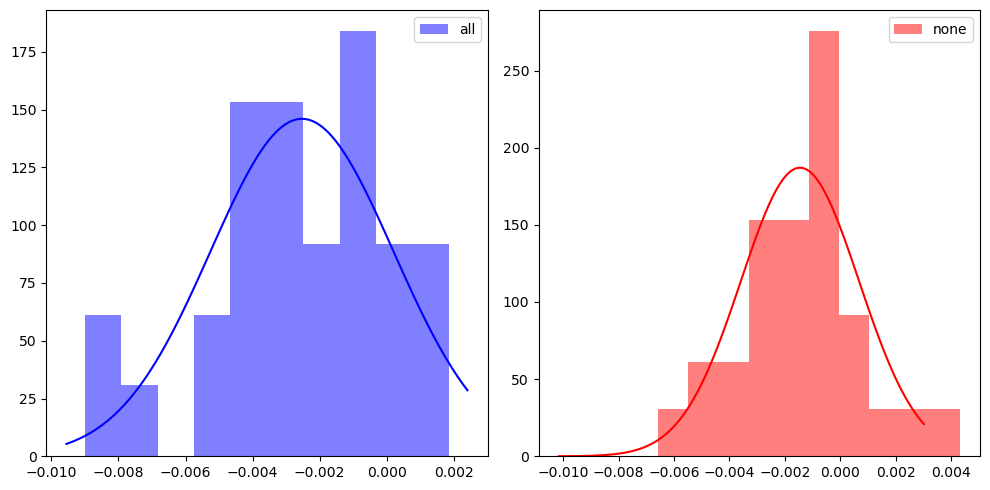

In [75]:
# comparison of the distribution of losses against a gaussian distribution
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs = axs.flatten()

axs[0].hist(global_val_losses[0],alpha=0.5,color='b',bins=10,label='all', density=True)
xmin, xmax = axs[0].get_xlim()  # Get the range of the x-axis
x = np.linspace(xmin, xmax, 100)
gauss = stats.norm.pdf(x, np.mean(global_val_losses[0]), np.std(global_val_losses[0]))
axs[0].plot(x, gauss, color='b')
axs[0].legend()

axs[1].hist(global_val_losses[1],alpha=0.5,color='r',bins=10,label='none', density=True)
xmin, xmax = axs[0].get_xlim()  # Get the range of the x-axis
x = np.linspace(xmin, xmax, 100)
gauss = stats.norm.pdf(x, np.mean(global_val_losses[1]), np.std(global_val_losses[1]))
axs[1].plot(x, gauss, color='r')
axs[1].legend()

fig.tight_layout()
plt.show()

In [68]:
# computes improvement and p-value
print(f'Model with 4 financial features has average loss over {k}-fold cv: {np.mean(global_val_losses[0])}')
print(f'Model without 4 financial features has average loss over {k}-fold cv: {np.mean(global_val_losses[1])}')
print(f'Improvement is: {(np.mean(global_val_losses[0])-np.mean(global_val_losses[1]))/np.mean(global_val_losses[1])*100} %\n')

t_stat, p_value = stats.ttest_rel(global_val_losses[0],global_val_losses[1])
print('Paired t-test has a p_value:', p_value)

w_stat, p_value_w = stats.wilcoxon(global_val_losses[0], global_val_losses[1])
print('Wilcoxon signed-rank test has a p_value:', p_value_w)

Model with 4 financial features has average loss over 30-fold cv: -0.0025267249380704015
Model without 4 financial features has average loss over 30-fold cv: -0.001458699613188704
Improvement is: 73.21763269320432 %

Paired t-test has a p_value: 0.044299743997085084
Wilcoxon signed-rank test has a p_value: 0.08406547829508781


#### Hyperparameter tuning

Analogous to Feature Subset Selection but with randomly searched configurations

##### 3-fold

In [16]:
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K

k = 3  # number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=15)
n_iter = 20 # how many random configurations get searched

In [52]:
# parameter search grid
param_grid = {
    'num_layers_eq': [1,2,3,4],
    'num_layers_fin': [1,2,3,4],
    'units_vector_eq': [1,2,4,8],
    'units_vector_fin': [1,2,4,8],
    'dense_units': [8,10,12],
    'dropout_rate': [0.0,0.2,0.4],
    'batch_normalization': [False, True]
}

In [18]:
# prepares the matrices which will be splitted with CV
X_for_cv = X_train[train_index+validation_index]
X_fin_for_cv = X_train_fin[train_index+validation_index]
lambda_for_cv = np.concatenate([train_lambda, valid_lambda], axis=0)
allocation_for_cv = np.concatenate([train_allocation, valid_allocation], axis=0)
y_for_cv = y_train[train_index+validation_index]

In [144]:
np.random.seed(3) # to make re-runs repeatable

random_search_losses = []

for iter in tqdm(range(n_iter)):
    num_layers_eq_rs = np.random.choice(param_grid['num_layers_eq'])
    num_layers_fin_rs = np.random.choice(param_grid['num_layers_fin'])
    units_vector_eq_rs = [int(np.random.choice(param_grid['units_vector_eq'])) for _ in range(num_layers_eq_rs)]
    units_vector_fin_rs = [int(np.random.choice(param_grid['units_vector_fin'])) for _ in range(num_layers_fin_rs)]
    dense_units_rs = np.random.choice(param_grid['dense_units'])
    dropout_rate_rs = np.random.choice(param_grid['dropout_rate'])
    batch_normalization_rs = np.random.choice(param_grid['batch_normalization'])

    # Step 4: Train and validate the model for each fold
    fold_no = 1
    val_losses_cv = []

    for train_index_cv, val_index_cv in kf.split(X_for_cv):
        # Split data
        X_train_lstm_cv = [X_for_cv[train_index_cv], X_fin_for_cv[train_index_cv], lambda_for_cv[train_index_cv], allocation_for_cv[train_index_cv]]
        X_val_lstm_cv = [X_for_cv[val_index_cv], X_fin_for_cv[val_index_cv], lambda_for_cv[val_index_cv], allocation_for_cv[val_index_cv]]
        y_train_cv = y_train[train_index_cv]
        y_val_cv = y_train[val_index_cv]

        # Create a new instance of the model
        model = SP500Perturbator(num_layers_eq=num_layers_eq_rs, num_layers_fin=num_layers_fin_rs, units_vector_eq=units_vector_eq_rs,
                                units_vector_fin=units_vector_fin_rs, dense_units=dense_units_rs, dropout_rate=dropout_rate_rs,
                                batch_normalization=batch_normalization_rs, penalty_coeff=penalty_coeff, use_transaction_costs=True,
                                transaction_coeff=transaction_coeff)
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer)
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True, verbose=1, start_from_epoch=5)
        model.build(input_shape=[(None, LAG_history, N*len(features_in_X)), (None, LAG_history_fin, N*len(features_in_X_fin)), (None, 1), (None, N)])

        history = model.fit(X_train_lstm_cv, y_train_cv, validation_data=(X_val_lstm_cv, y_val_cv), epochs=epochs,
                            batch_size=batch_size, callbacks=[early_stopping], shuffle=True, verbose=0)
        
        # Get the validation loss for the current fold
        val_loss = min(history.history['val_loss'])
        val_losses_cv.append(val_loss)
        
        print(f'Fold {fold_no} - Best Validation Loss: {val_loss}')
        fold_no += 1
        
        K.clear_session()

    random_search_losses.append(val_losses_cv)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 105: early stopping
Restoring model weights from the end of the best epoch: 85.
Fold 1 - Best Validation Loss: -0.0006273682229220867


100%|██████████| 20/20 [01:57<00:00,  5.88s/it]


In [22]:
np.mean(random_search_losses, axis=1)

array([ 2.45272124e-04,  4.86708343e-04, -5.78506054e-05, -1.02461778e-04,
        9.30717525e-04,  6.63151780e-04,  1.15796121e-04,  1.31670714e-04,
        1.10889469e-03,  7.40611829e-04, -2.48286119e-04,  9.15928103e-06,
        2.08082361e-04,  5.49165818e-04,  2.50733370e-04,  5.12326951e-04,
        4.49440379e-04,  2.66446548e-04, -1.20227400e-04,  4.81097998e-04])

In [61]:
# to print the best performing configuration
np.random.seed(3)

for iter in tqdm(range(n_iter)):
    num_layers_eq_rs = np.random.choice(param_grid['num_layers_eq'])
    num_layers_fin_rs = np.random.choice(param_grid['num_layers_fin'])
    units_vector_eq_rs = [int(np.random.choice(param_grid['units_vector_eq'])) for _ in range(num_layers_eq_rs)]
    units_vector_fin_rs = [int(np.random.choice(param_grid['units_vector_fin'])) for _ in range(num_layers_fin_rs)]
    dense_units_rs = np.random.choice(param_grid['dense_units'])
    dropout_rate_rs = np.random.choice(param_grid['dropout_rate'])
    batch_normalization_rs = np.random.choice(param_grid['batch_normalization'])

    if iter == np.mean(random_search_losses, axis=1).tolist().index(np.mean(random_search_losses, axis=1).min()):
        print(f'{iter}-th iteration has minimum loss: {np.mean(random_search_losses, axis=1).min()}')
        print(f'Eq layers: {num_layers_eq_rs} with neurons: {units_vector_eq_rs}\n'+f'Fin layers: {num_layers_fin_rs} with neurons: {units_vector_fin_rs}\n'+
              f'Relu dense neurons: {dense_units_rs}\n'+f'Dropout: {dropout_rate_rs}\n'+f'Batch normalization: {batch_normalization_rs}\n')

100%|██████████| 20/20 [00:00<00:00, 2944.51it/s]

10-th iteration has minimum loss: -0.00024828611882791546
Eq layers: 1 with neurons: [2]
Fin layers: 2 with neurons: [1, 2]
Relu dense neurons: 8
Dropout: 0.4
Batch normalization: False



##### 30-fold + test

In [8]:
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K

k = 30  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=15)

use_transaction_costs_rs = False

In [31]:
X_for_cv = X_train[train_index+validation_index]
X_fin_for_cv = X_train_fin[train_index+validation_index]
lambda_for_cv = np.concatenate([train_lambda, valid_lambda], axis=0)
allocation_for_cv = np.concatenate([train_allocation, valid_allocation], axis=0)
y_for_cv = y_train[train_index+validation_index]

In [ ]:
# compares the best performing configuration with the simplest one (1 layer 1 neuron for both LSTM pipelines)
configurations = [[1, 2, [2], [1,2], 8, 0.4, False], [1, 1, [1], [1], 8, 0.0, False]]
np.random.seed(3)

global_val_losses = []

for config in tqdm(configurations):
    num_layers_eq_rs, num_layers_fin_rs, units_vector_eq_rs, units_vector_fin_rs, dense_units_rs, dropout_rate_rs, batch_normalization_rs = config

    # Step 4: Train and validate the model for each fold
    fold_no = 1
    val_losses_cv = []

    for train_index_cv, val_index_cv in kf.split(X_for_cv):
        val_loss = np.nan
        while np.isnan(val_loss):
            # Split data
            X_train_lstm_cv = [X_for_cv[train_index_cv], X_fin_for_cv[train_index_cv], lambda_for_cv[train_index_cv], allocation_for_cv[train_index_cv]]
            X_val_lstm_cv = [X_for_cv[val_index_cv], X_fin_for_cv[val_index_cv], lambda_for_cv[val_index_cv], allocation_for_cv[val_index_cv]]
            y_train_cv = y_train[train_index_cv]
            y_val_cv = y_train[val_index_cv]

            # Create a new instance of the model
            model = SP500Perturbator(num_layers_eq=num_layers_eq_rs, num_layers_fin=num_layers_fin_rs, units_vector_eq=units_vector_eq_rs,
                                    units_vector_fin=units_vector_fin_rs, dense_units=dense_units_rs, dropout_rate=dropout_rate_rs,
                                    batch_normalization=batch_normalization_rs, penalty_coeff=penalty_coeff, use_transaction_costs=use_transaction_costs_rs,
                                    transaction_coeff=transaction_coeff)
            optimizer = Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer)
            early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True, verbose=1, start_from_epoch=5)
            model.build(input_shape=[(None, LAG_history, N*len(features_in_X)), (None, LAG_history_fin, N*len(features_in_X_fin)), (None, 1), (None, N)])

            history = model.fit(X_train_lstm_cv, y_train_cv, validation_data=(X_val_lstm_cv, y_val_cv), epochs=epochs,
                                batch_size=batch_size, callbacks=[early_stopping], shuffle=True, verbose=0)
            
            # Get the validation loss for the current fold
            val_loss = min(history.history['val_loss'])
        
            K.clear_session()

        print(f'Fold {fold_no} - Best Validation Loss: {val_loss}')
        fold_no += 1

        val_losses_cv.append(val_loss)

    global_val_losses.append(val_losses_cv)

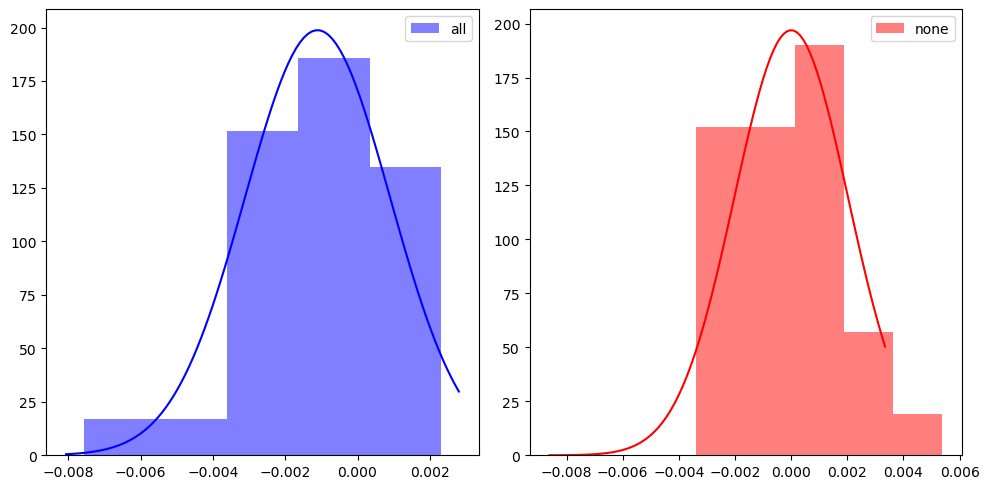

In [16]:
# compares the losses distribution against a gaussian distribution
bins = 5
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs = axs.flatten()

axs[0].hist(global_val_losses[0],alpha=0.5,color='b',bins=bins,label='all', density=True)
xmin, xmax = axs[0].get_xlim()  # Get the range of the x-axis
x = np.linspace(xmin, xmax, 100)
gauss = stats.norm.pdf(x, np.mean(global_val_losses[0]), np.std(global_val_losses[0]))
axs[0].plot(x, gauss, color='b')
axs[0].legend()

axs[1].hist(global_val_losses[1],alpha=0.5,color='r',bins=bins,label='none', density=True)
xmin, xmax = axs[0].get_xlim()  # Get the range of the x-axis
x = np.linspace(xmin, xmax, 100)
gauss = stats.norm.pdf(x, np.mean(global_val_losses[1]), np.std(global_val_losses[1]))
axs[1].plot(x, gauss, color='r')
axs[1].legend()

fig.tight_layout()
plt.show()

In [17]:
# computes the improvement and the p-value
print(f'Best model from hyperparameter tuning has average loss over {k}-fold cv: {np.mean(global_val_losses[0])}')
print(f'Simplest possible model has average loss over {k}-fold cv: {np.mean(global_val_losses[1])}')
print(f'Improvement is: {np.abs((np.mean(global_val_losses[0])-np.mean(global_val_losses[1]))/np.mean(global_val_losses[1]))*100} %\n')

t_stat, p_value = stats.ttest_rel(global_val_losses[0],global_val_losses[1])
print('Paired t-test has a p_value:', p_value)

w_stat, p_value_w = stats.wilcoxon(global_val_losses[0], global_val_losses[1])
print('Wilcoxon signed-rank test has a p_value:', p_value_w)

Best model from hyperparameter tuning has average loss over 30-fold cv: -0.001106382184176861
Simplest possible model has average loss over 30-fold cv: 5.92547197205325e-07
Improvement is: 186816.2969287467 %

Paired t-test has a p_value: 0.008209616760389733
Wilcoxon signed-rank test has a p_value: 0.00466480478644371


### Saving & loading

Select directory

In [14]:
# file name to save the models and histories
if OBJECTIVE == 'OPTIMIZATION':
    directory = f'{MODELS_DIRECTORY}/LSTM/SP500 PERTURBATION/LAG HISTORY {LAG_history} & LAG FIN {LAG_history_fin} & N FUTURES {N_futures}/FEATURES_{features_in_X}+{features_in_X_fin} - TARGET_{target_in_y}/TOP {N} TICKERS/'

    if (num_layers_eq == 1) and (num_layers_fin == 1):
        file_name = f'{penalty_coeff}penalty_EQ{num_layers_eq}layers' + 'x'.join(str(units_eq[i]) for i in range(num_layers_eq)) + f'_FIN{num_layers_fin}layers' + 'x'.join(str(units_fin[i]) for i in range(num_layers_fin)) + f'_{dense_units}dense_{batch_size}batches_{epochs}epochs_top{N}_learningrate{learning_rate}'
    else:
        if batch_normalization:
            file_name = f'{penalty_coeff}penalty_EQ{num_layers_eq}layers' + 'x'.join(str(units_eq[i]) for i in range(num_layers_eq)) + f'_FIN{num_layers_fin}layers' + 'x'.join(str(units_fin[i]) for i in range(num_layers_fin)) + f'_{dense_units}dense_{batch_size}batches_{epochs}epochs_top{N}_learningrate{learning_rate}_{dropout_rate}dropout_batchnormalization'
        else:
            file_name = f'{penalty_coeff}penalty_EQ{num_layers_eq}layers' + 'x'.join(str(units_eq[i]) for i in range(num_layers_eq)) + f'_FIN{num_layers_fin}layers' + 'x'.join(str(units_fin[i]) for i in range(num_layers_fin)) + f'_{dense_units}dense_{batch_size}batches_{epochs}epochs_top{N}_learningrate{learning_rate}_{dropout_rate}dropout'

Save model & history

In [ ]:
"""
we save both the model and histories related to the model that minimzes transaction costs (T_)
and those related to the model that does NOT minimize transaction costs (NT_)
"""
os.makedirs(directory, exist_ok=True)
os.chdir(directory)
if os.path.exists('T_'+file_name+'.keras') or os.path.exists('NT_'+file_name+'.keras'):
    print('Models with the same name already exists!')
else:
    # Save Tensorflow model
    no_transaction_model.save('NT_'+file_name+'.keras')
    transaction_model.save(f'T_{transaction_coeff}transaction_'+file_name+'.keras')
    # Save history in pickle file
    os.makedirs(directory+'/HISTORY', exist_ok=True)

    file_path = os.path.join(directory, 'HISTORY/'+'NT_'+file_name+'.pkl')
    with open(file_path, 'wb') as file:
        pickle.dump(history_no_trans, file)
    file_path = os.path.join(directory, 'HISTORY/'+f'T_{transaction_coeff}transaction_'+file_name+'.pkl')
    with open(file_path, 'wb') as file:
        pickle.dump(history_trans, file)

    print('New model saved!')

Load model & history

In [ ]:
# to load the saved model and histories
os.chdir(directory)
no_transaction_model = tf.keras.models.load_model('NT_'+file_name+'.keras')
transaction_model = tf.keras.models.load_model(f'T_{transaction_coeff}transaction_'+file_name+'.keras')

file_path = os.path.join(directory, 'HISTORY/'+'NT_'+file_name+'.pkl')
with open(file_path, 'rb') as file:
    history_no_trans = pickle.load(file)
file_path = os.path.join(directory, 'HISTORY/'+f'T_{transaction_coeff}transaction_'+file_name+'.pkl')
with open(file_path, 'rb') as file:
    history_trans = pickle.load(file)

print(f'Loaded model!')

### Plotting

To plot training and validation losses

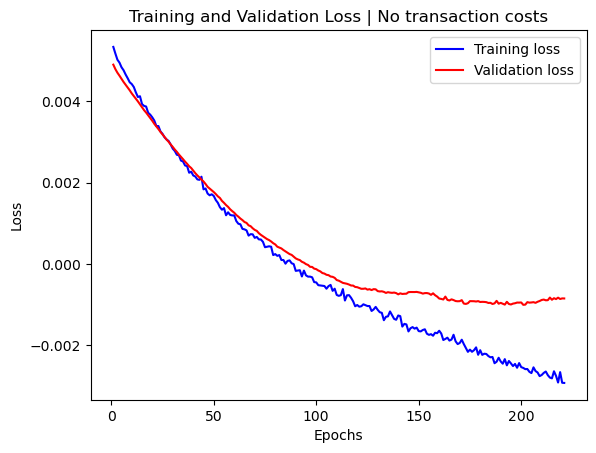

In [50]:
train_loss_no_trans = history_no_trans.history['loss']
validation_loss_no_trans = history_no_trans.history['val_loss']

# Creating a line plot
plot_epochs = range(1, len(train_loss_no_trans)+1)
plt.plot(plot_epochs, train_loss_no_trans, 'b', label='Training loss')
plt.plot(plot_epochs, validation_loss_no_trans, 'r', label='Validation loss')

plt.title('Training and Validation Loss | No transaction costs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

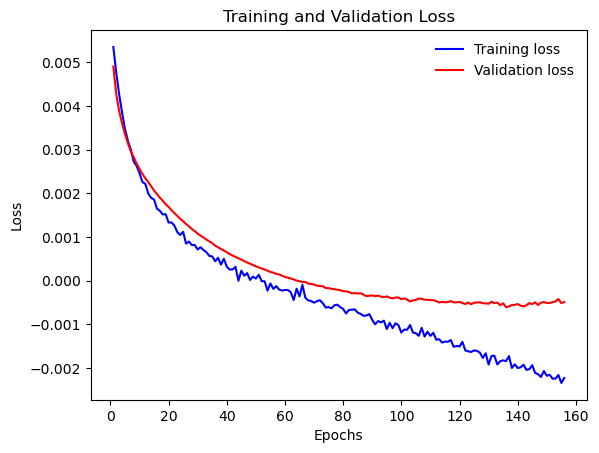

In [45]:
train_loss_trans = history_trans.history['loss']
validation_loss_trans = history_trans.history['val_loss']

# Creating a line plot
plot_epochs = range(1, len(train_loss_trans)+1)
plt.plot(plot_epochs, train_loss_trans, 'b', label='Training loss')
plt.plot(plot_epochs, validation_loss_trans, 'r', label='Validation loss')

plt.title('Training and Validation Loss | With transaction costs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(framealpha=0)
plt.show()

### Predictions

Given that we minimize transaction costs across consecutive time steps, we employ a rolling-forward loop in which the generated allocation at time $t$ is used as input for the $t+1$ allocation

In [16]:
def get_test_weights(lambda_ra, disable_tqdm=False):
    test_weights = []

    lambda_vector = np.full((len(X_test), 1), lambda_ra)

    for i in tqdm(range(len(X_test_lstm[0])), disable=disable_tqdm):
        # first day allocation is generated by the model that does NOT minimize transaction costs
        if i == 0:
            old_prediction = no_transaction_model.predict([X_test[:1], X_test_fin[:1], lambda_vector[:1], np.array([0]*N).reshape(1,-1)], verbose=0)
            old_allocation = old_prediction / np.sum(np.abs(old_prediction), axis=1, keepdims=True)
            test_weights.append(old_allocation)
        else:
            new_prediction = transaction_model.predict([X_test[i:i+1], X_test_fin[i:i+1], lambda_vector[i:i+1], old_allocation], verbose=0)
            new_allocation = new_prediction / np.sum(np.abs(new_prediction), axis=1, keepdims=True)
            test_weights.append(new_allocation)
            old_allocation = new_allocation

    test_weights = np.concatenate(test_weights, axis=0)

    return test_weights

In [17]:
train_predict = transaction_model.predict(X_train_lstm, batch_size=128)
valid_predict = transaction_model.predict(X_valid_lstm, batch_size=128)
# the model without transaction costs minimization can predict easily
test_predict_no_trans = no_transaction_model.predict(X_test_lstm, batch_size=128)
# the model with transaction costs minimization must employ the rolling-forward loop
test_weights = get_test_weights(risk_aversion)

2024-10-22 16:13:56.243149: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|██████████| 540/540 [00:30<00:00, 17.86it/s]


In [18]:
# norm-1 normalization of weights
train_weights = train_predict / np.sum(np.abs(train_predict), axis=1, keepdims=True)
valid_weights = valid_predict / np.sum(np.abs(valid_predict), axis=1, keepdims=True)
test_weights_no_trans = test_predict_no_trans / np.sum(np.abs(test_predict_no_trans), axis=1, keepdims=True)

In [19]:
# addition to the support dataframes
train_support['perturbed_weights'] = 0
test_support['perturbed_weights'] = 0

train_support.loc[train_index_df & (train_support.marketcap_rank <= N), 'perturbed_weights'] = train_weights.flatten()
train_support.loc[validation_index_df & (train_support.marketcap_rank <= N), 'perturbed_weights'] = valid_weights.flatten()
test_support.loc[test_support.marketcap_rank <= N, 'perturbed_weights'] = test_weights.flatten()
test_support.loc[test_support.marketcap_rank <= N, 'perturbed_weights_no_trans'] = test_weights_no_trans.flatten()

#### Distance test

We check if the transaction costs minimization term actually reduces the distance among consecutive time steps in a statistically significant way

In [21]:
# we compute the coside distance matrix
norm_test_weights = test_weights / np.linalg.norm(test_weights, ord=2, axis=1, keepdims=True)
cosine_similarity_matrix = np.dot(norm_test_weights, norm_test_weights.T)
cosine_distance_matrix = 1 - cosine_similarity_matrix

random_weights = np.random.normal(loc=0, scale=0.1, size=(len(norm_test_weights), N))
random_weights /= np.linalg.norm(random_weights, ord=2, axis=1, keepdims=True)
random_distance_matrix = 1.0 - np.dot(random_weights, random_weights.T)

norm_test_weights_no_trans = test_weights_no_trans / np.linalg.norm(test_weights_no_trans, ord=2, axis=1, keepdims=True)
cosine_similarity_matrix_no_trans = np.dot(norm_test_weights_no_trans, norm_test_weights_no_trans.T)
cosine_distance_matrix_no_trans = 1 - cosine_similarity_matrix_no_trans

sample_size = 50  # Choose a smaller sample size
indices = np.random.choice(cosine_distance_matrix.shape[0], sample_size, replace=False)
sampled_matrix = cosine_distance_matrix[np.ix_(indices, indices)]

In [28]:
# we extract the consecutive time distances, compute improvement and p-value
distances = [cosine_distance_matrix[i,i+1] for i in range(len(norm_test_weights)-1)]
distances_no_trans = [cosine_distance_matrix_no_trans[i,i+1] for i in range(len(norm_test_weights_no_trans)-1)]
random_distances = [random_distance_matrix[i,i+1] for i in range(len(random_weights)-1)]

print(f'Average cosine distance between test predictions: {np.mean(distances)}')
print(f'Average cosine distance between test predictions (no trans. costs minimization): {np.mean(distances_no_trans)}')
print(f'Improvement is: {(np.mean(distances_no_trans) - np.mean(distances))/np.mean(distances_no_trans)*100} %')
print(f'Average cosine distance between random predictions: {np.mean(random_distances)}')
print()

w_stat_compm, p_value_w_comp = stats.wilcoxon(distances, distances_no_trans)
print(f'Wilcoxon (trans vs no trans) has p_value: {p_value_w_comp}')
w_stat, p_value_w = stats.wilcoxon(distances, random_distances)
print(f'Wilcoxon signed-rank test (trans vs market cap) has p_value: {p_value_w}')

Average cosine distance between test predictions: 0.04276082292199135
Average cosine distance between test predictions (no trans. costs minimization): 0.05981609597802162
Improvement is: 28.512847423553467 %
Average cosine distance between random predictions: 1.0024378291998024

Wilcoxon (trans vs no trans) has p_value: 0.0009399769691498376
Wilcoxon signed-rank test (trans vs market cap) has p_value: 5.42275789527015e-90


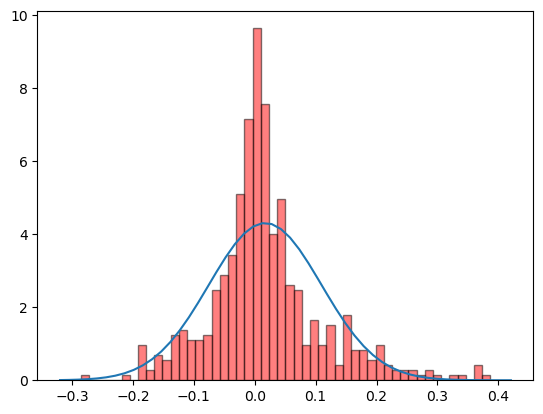

In [34]:
from scipy.stats import norm

# we compare the differences distribution against a gaussian distribution
differences = np.array(distances_no_trans)-np.array(distances)
plt.hist(differences, alpha=0.5, color='red', edgecolor='black', bins=50, density=True)

x_min, x_max = plt.xlim()

mu = np.mean(differences)
std = np.std(differences)
x_lin = np.linspace(x_min,x_max)
pdf = norm.pdf(x_lin, mu, std)
plt.plot(x_lin, pdf)

In [32]:
# compute the L1 norm difference across consecutive samples
l1_differences_trans = np.sum(np.abs(norm_test_weights[1:] - norm_test_weights[:-1]), axis=1)
l1_differences_no_trans = np.sum(np.abs(norm_test_weights_no_trans[1:] - norm_test_weights_no_trans[:-1]), axis=1)

# compute improvement and p-value
print(f'Average cosine distance between test predictions: {np.mean(l1_differences_trans)}')
print(f'Average cosine distance between test predictions (no trans. costs minimization): {np.mean(l1_differences_no_trans)}')
print(f'Improvement is: {(np.mean(l1_differences_no_trans) - np.mean(l1_differences_trans))/np.mean(l1_differences_no_trans)*100} %')
print()

w_stat_compm, p_value_w_comp = stats.wilcoxon(l1_differences_trans, l1_differences_no_trans)
print(f'Wilcoxon (trans vs no trans) L1 distances has p_value: {p_value_w_comp}')

Average cosine distance between test predictions: 4.4129638671875
Average cosine distance between test predictions (no trans. costs minimization): 5.096486568450928
Improvement is: 13.411645591259003 %

Wilcoxon (trans vs no trans) L1 distances has p_value: 0.004458513497601287


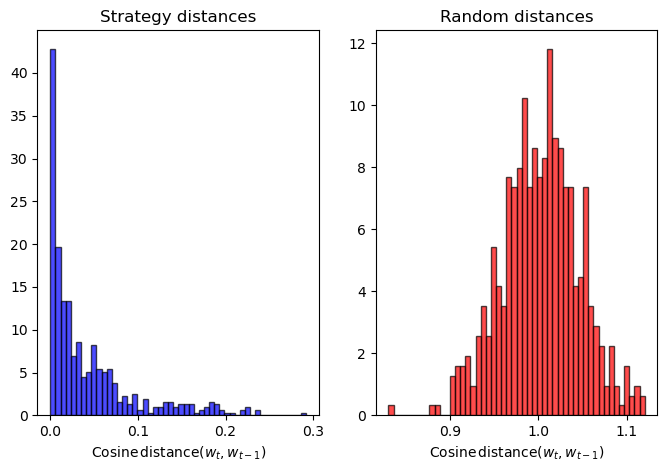

In [38]:
# compare the distributions of distances against random gaussian distances (unit test)
fig, axs = plt.subplots(1,2, figsize=(8,5))
axs[0].hist(distances, color='b', label='Strategy', bins=50, alpha=0.7, edgecolor='black', density=True)
# axs[0].hist(distances_no_trans, color='green', label='Strategy', bins=50, alpha=0.7, edgecolor='black', density=True)
axs[0].set_title('Strategy distances')
axs[0].set_xlabel(r'$\mathrm{Cosine\,distance}\left(w_t,w_{t-1}\right)$')
axs[1].hist(random_distances, color='r', label='Random', bins=50, alpha=0.7, edgecolor='black', density=True)
axs[1].set_title('Random distances')
axs[1].set_xlabel(r'$\mathrm{Cosine\,distance}\left(w_t,w_{t-1}\right)$')
plt.show()

### Strategy

Generate the strategy by multiplying returns and portfolio-weights

In [21]:
for supp in [train_support, test_support]:
    supp['strategy_returns_weighted'] = supp['log_return_fut1']*supp['perturbed_weights']

    supp['perturbed_weights_lag1'] = supp.groupby('ticker')['perturbed_weights'].shift(1).fillna(0)
    supp['transaction_costs'] = np.abs(supp['perturbed_weights'] - supp['perturbed_weights_lag1']) * transaction_coeff
    supp['strategy_with_trans_costs'] = supp['strategy_returns_weighted'] - supp['transaction_costs']
    
    supp['strategy_without_trans_costs'] = supp['strategy_returns_weighted']

test_support['strategy_old_model'] = test_support['log_return_fut1']*test_support['perturbed_weights_no_trans']

#### Profit & loss

We plot cumulative returns against time to see how the strategy behaves

In plotting, we move from logarithmic to linear for a clearer representation 

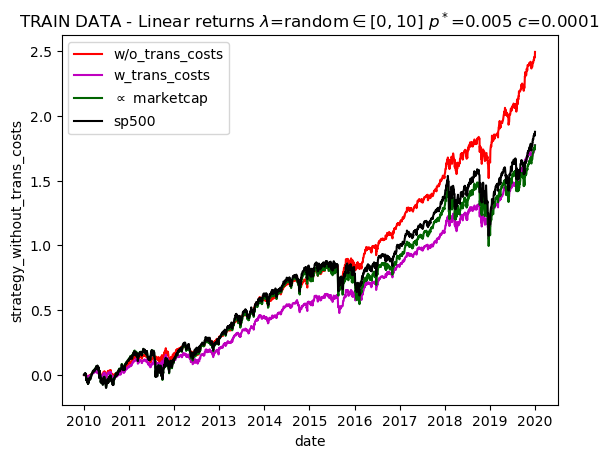

In [30]:
sns.lineplot(np.exp(train_support[train_index_df].groupby(df_date)['strategy_without_trans_costs'].sum().cumsum())-1, label='w/o_trans_costs', color='r')
sns.lineplot(np.exp(train_support[train_index_df].groupby(df_date)['strategy_with_trans_costs'].sum().cumsum())-1, label='w_trans_costs', color='m')
sns.lineplot(np.exp(train_support[train_index_df].groupby(df_date)['artificial_index'].sum().cumsum())-1, label=r'$\propto$ marketcap', color='darkgreen')
sns.lineplot(np.exp(sp500[(sp500[df_date]<validation_date) & (sp500[df_date]>=start_date)].groupby(df_date)['index_log_return_fut1'].mean().cumsum())-1, label='sp500', color='k')
plt.title(fr'TRAIN DATA - Linear returns $\lambda$=random$\in[0,10]$ $p^*$={penalty_coeff} $c$={transaction_coeff}')
plt.show()

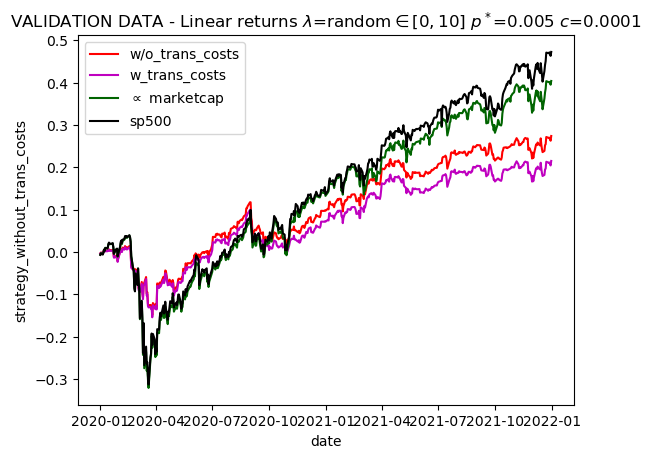

In [31]:
sns.lineplot(np.exp(train_support[validation_index_df].groupby(df_date)['strategy_without_trans_costs'].sum().cumsum())-1, label='w/o_trans_costs', color='r')
sns.lineplot(np.exp(train_support[validation_index_df].groupby(df_date)['strategy_with_trans_costs'].sum().cumsum())-1, label='w_trans_costs', color='m')
sns.lineplot(np.exp(train_support[validation_index_df].groupby(df_date)['artificial_index'].sum().cumsum())-1, label=r'$\propto$ marketcap', color='darkgreen')
sns.lineplot(np.exp(sp500[(sp500[df_date]>=validation_date) & (sp500[df_date]<split_date)].groupby(df_date)['index_log_return_fut1'].mean().cumsum())-1, label='sp500', color='k')
plt.title(fr'VALIDATION DATA - Linear returns $\lambda$=random$\in[0,10]$ $p^*$={penalty_coeff} $c$={transaction_coeff}')
plt.show()

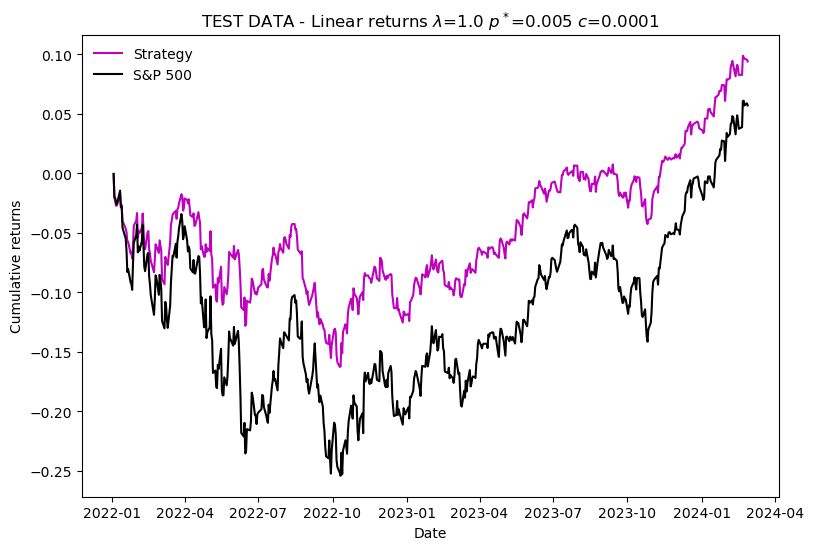

In [58]:
plt.figure(figsize=(9,6))
sns.lineplot(np.exp(test_support.groupby(df_date)['strategy_with_trans_costs'].sum().cumsum())-1, label='Strategy', color='m')
sns.lineplot(np.exp(sp500[sp500[df_date]>=split_date].iloc[:-10].groupby(df_date)['index_log_return_fut1'].mean().cumsum())-1, label='S&P 500', color='k')

plt.title(fr'TEST DATA - Linear returns $\lambda$={risk_aversion} $p^*$={penalty_coeff} $c$={transaction_coeff}')
plt.ylabel('Cumulative returns')
plt.xlabel('Date')
plt.legend(framealpha=0)
plt.show()

Comparison of the reference S&P 500 strategy (i.e. $\propto$ marketcap) and the generated strategy weights

WilcoxonResult(statistic=7697286756.0, pvalue=0.0)


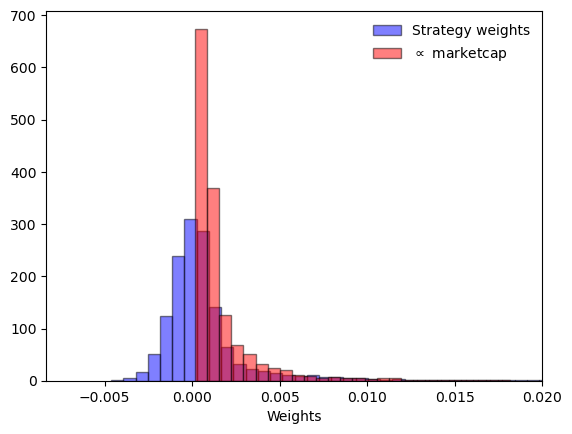

In [30]:
strat_weights = test_support[test_support.marketcap_rank <= N]['perturbed_weights'].values
mcap_ratio = test_support[test_support.marketcap_rank <= N]['marketcap_ratio'].values

print(stats.wilcoxon(strat_weights, mcap_ratio))

plt.hist(strat_weights, alpha=0.5, color='b', edgecolor='black', label='Strategy weights', bins=100, density=True)
plt.hist(mcap_ratio, alpha=0.5, color='r', edgecolor='black', label=r'$\propto$ marketcap', bins=100, density=True)
plt.xlabel('Weights')
plt.xlim(right=0.02) # capped to remove outliers (high-cap weights) from visualization 
plt.legend(framealpha=0.0)
# plt.savefig('strategy_vs_marketcap_capped.png', format='png', dpi=700, transparent=True)
plt.show()

### $\lambda$-plot

By varying the risk-aversion parameter $\lambda$ we generate multiple allocation strategies that we can compare with the reference S&P 500 index

In [22]:
last_date = test_support.date.max()

#### Functions

In [23]:
# compute the tracking error
def get_tracking_error(portfolio_strat_log, sp500_supp):
    portfolio_lin_daily_ret = np.exp(portfolio_strat_log) - 1
    sp500_lin_daily_ret = np.exp(sp500_supp['index_log_return_fut1']) - 1

    excess_returns = portfolio_lin_daily_ret - sp500_lin_daily_ret
    tracking_error = np.std(excess_returns, ddof=1)

    return tracking_error

In [24]:
"""
compute useful metrics that can be plotted against λ:
    - mean-variance utility function
    - portfolio returns
    - portfolio risk
    - portfolio sharpe ratio (the actual Sharpe ratio would need to take into account the yearly interest rates!!!)
    - max drawdown
    - tracking error
"""
def get_metrics(support, lambda_vector, sp500_supp=sp500[(sp500.date>=split_date) & (sp500.date<=last_date)]):
    n_days = support.date.nunique()

    utility_vector = np.empty(len(lambda_vector))
    sharpe_vector = np.empty(len(lambda_vector))
    risk_vector = np.empty(len(lambda_vector))
    returns_vector = np.empty(len(lambda_vector))
    max_drawdown_vector = np.empty(len(lambda_vector))
    tracking_error_vector = np.empty(len(lambda_vector))

    i = 0

    for lambda_ra in tqdm(lambda_vector):
        test_weights = get_test_weights(lambda_ra, disable_tqdm=True)
        support.loc[support.marketcap_rank <= N, 'perturbed_weights'] = test_weights.flatten()

        support['strategy_returns_weighted'] = support['log_return_fut1']*support['perturbed_weights']
        support['perturbed_weights_lag1'] = support.groupby('ticker')['perturbed_weights'].shift(1).fillna(0)
        support['transaction_costs'] = np.abs(support['perturbed_weights'] - support['perturbed_weights_lag1']) * transaction_coeff
        support['strategy_with_trans_costs'] = support['strategy_returns_weighted'] - support['transaction_costs']
    
        # we move from logarithmic to linear
        linear_returns = (np.exp(support.groupby('date')['strategy_with_trans_costs'].sum().sum()) - 1) * 252 / n_days
        linear_risk =  (np.exp(support.groupby('date')['strategy_with_trans_costs'].sum()) - 1).std() * np.sqrt(252)

        utility = linear_returns - lambda_ra * 0.5 * (linear_risk**2)
        sharpe = linear_returns / linear_risk

        cumulative_wealth = np.exp(support.groupby('date')['strategy_with_trans_costs'].sum().cumsum()) 
        running_max = np.maximum.accumulate(cumulative_wealth)        # running max of cumulative returns
        drawdowns = (cumulative_wealth - running_max) / running_max   # drawdown calculation

        # either max drawdown or the 95th percentile
        max_drawdown = np.min(drawdowns)
        # percentile_95_drawdown = np.percentile(drawdowns, 5) # 95th percentile drawdown (5 since drawdowns are negative) 

        utility_vector[i] = utility
        sharpe_vector[i] = sharpe
        risk_vector[i] = linear_risk
        returns_vector[i] = linear_returns
        max_drawdown_vector[i] = max_drawdown
        # max_drawdown_vector[i] = percentile_95_drawdown
        tracking_error_vector[i] = get_tracking_error(support['strategy_with_trans_costs'], sp500_supp)

        i += 1

    return utility_vector, sharpe_vector, risk_vector, returns_vector, max_drawdown_vector, tracking_error_vector

In [25]:
# same as above but computed for the reference index (which is unaffected by λ)
def get_sp500_metrics(sp500_supp, lambda_vector):
    n_days = sp500_supp.date.nunique()

    utility_vector = np.empty(len(lambda_vector))
    sharpe_vector = np.empty(len(lambda_vector))
    risk_vector = np.empty(len(lambda_vector))
    returns_vector = np.empty(len(lambda_vector))
    max_drawdown_vector = np.empty(len(lambda_vector))

    for i, lambda_ra in enumerate(lambda_vector):    
        linear_returns = (np.exp(sp500_supp['index_log_return_fut1'].sum()) - 1) * 252 / n_days
        linear_risk =  (np.exp(sp500_supp['index_log_return_fut1']) - 1).std() * np.sqrt(252)

        utility = linear_returns - lambda_ra * 0.5 * (linear_risk**2)
        sharpe = linear_returns / linear_risk

        cumulative_wealth = np.exp(sp500_supp['index_log_return_fut1'].cumsum())
        running_max = np.maximum.accumulate(cumulative_wealth)        # Running max of cumulative returns
        drawdowns = (cumulative_wealth - running_max) / running_max   # Drawdown calculation
        max_drawdown = np.min(drawdowns) 
        # percentile_95_drawdown = np.percentile(drawdowns, 5) # 95th percentile drawdown (5 since drawdowns are negative) 

        utility_vector[i] = utility
        sharpe_vector[i] = sharpe
        risk_vector[i] = linear_risk
        returns_vector[i] = linear_returns
        max_drawdown_vector[i] = max_drawdown
        # max_drawdown_vector[i] = percentile_95_drawdown

    return utility_vector, sharpe_vector, risk_vector, returns_vector, max_drawdown_vector

#### Analysis

In [26]:
# values of λ to test (reference in thesis suggests to choose in [1,10])
lambda_vector = np.linspace(1.0, high_lambda, 40)

In [27]:
# computes the metrics
test_utility, test_sharpe, test_risk, test_returns, test_max_drawdown, test_tracking_error = get_metrics(test_support, lambda_vector)
sp500_utility, sp500_sharpe, sp500_risk, sp500_returns, sp500_max_drawdown = get_sp500_metrics(sp500[(sp500.date>=split_date) & (sp500.date<=last_date)], lambda_vector)

100%|██████████| 40/40 [26:37<00:00, 39.95s/it]


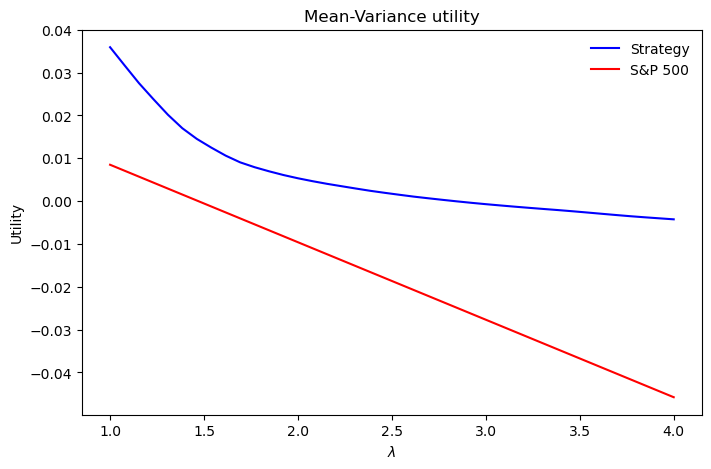

In [105]:
plt.figure(figsize=(8,5))
sns.lineplot(x=lambda_vector, y=test_utility, color='b', label='Strategy')
sns.lineplot(x=lambda_vector, y=sp500_utility, color='r', label='S&P 500')
plt.title('Mean-Variance utility')
plt.xlabel(r'$\lambda$')
plt.ylabel('Utility')
plt.legend(framealpha=0.0)
# plt.savefig('utility_lambda_plot.png', format='png', dpi=700, transparent=True)
plt.show()

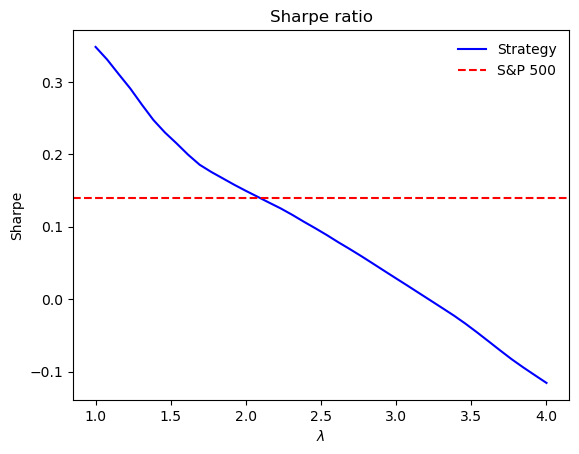

In [106]:
# the actual Sharpe ratio would need to take into account the yearly interest rates!!!

sns.lineplot(x=lambda_vector, y=test_sharpe, color='b', label='Strategy')
# sns.lineplot(x=lambda_vector, y=sp500_sharpe, color='r', label='sp500')
plt.axhline(y=sp500_sharpe[0], color='r', linestyle='--', label='S&P 500')
plt.title('Sharpe ratio')
plt.xlabel(r'$\lambda$')
plt.ylabel('Sharpe')
plt.legend(framealpha=0.0)
# plt.savefig('sharpe_lambda_plot.png', format='png', dpi=700, transparent=True)
plt.show()

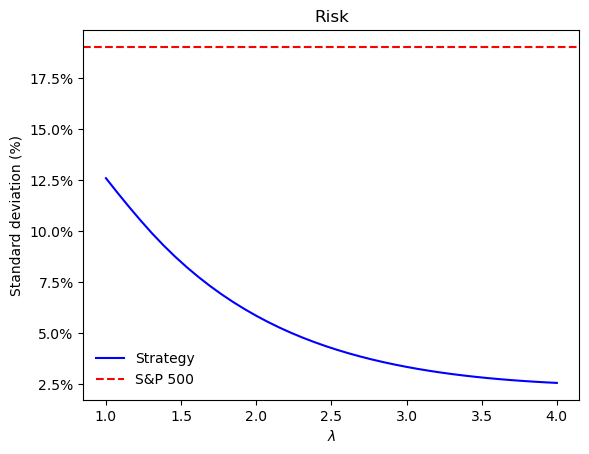

In [107]:
sns.lineplot(x=lambda_vector, y=test_risk, color='b', label='Strategy')
# sns.lineplot(x=lambda_vector, y=sp500_risk, color='r', label='sp500')
plt.axhline(y=sp500_risk[0], color='r', linestyle='--', label='S&P 500')
plt.title('Risk')
plt.xlabel(r'$\lambda$')
plt.ylabel('Standard deviation (%)')
plt.legend(framealpha=0.0)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # The argument 1 means the data is between 0 and 1

# plt.savefig('risk_lambda_plot.png', format='png', dpi=700, transparent=True)
plt.show()

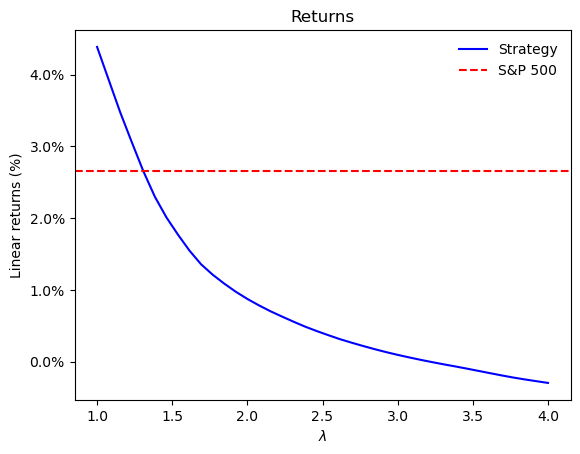

In [108]:
sns.lineplot(x=lambda_vector, y=test_returns, color='b', label='Strategy')
# sns.lineplot(x=lambda_vector, y=sp500_risk, color='r', label='sp500')
plt.axhline(y=sp500_returns[0], color='r', linestyle='--', label='S&P 500')
plt.title('Returns')
plt.xlabel(r'$\lambda$')
plt.ylabel('Linear returns (%)')
plt.legend(framealpha=0.0)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # The argument 1 means the data is between 0 and 1

# plt.savefig('returns_lambda_plot.png', format='png', dpi=700, transparent=True)
plt.show()

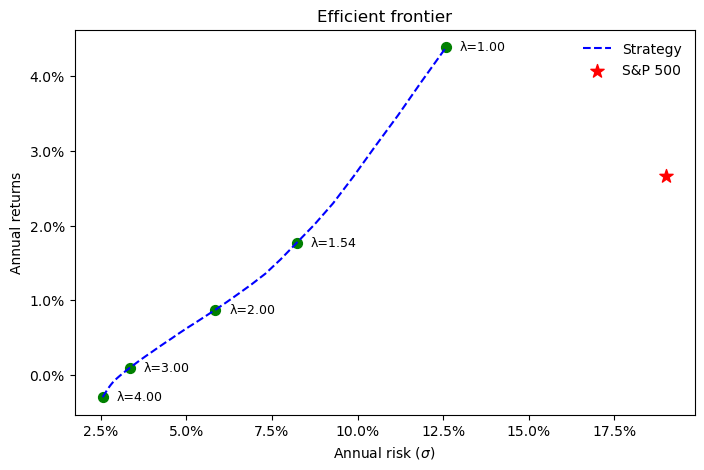

In [30]:
"""
the ex-post efficient frontier is a plot of annualized returns against annualized risk
can be used to evaluate how the generated strategies perform against the market benchmark
"""

plt.figure(figsize=(8,5))

sns.lineplot(x=test_risk, y=test_returns, color='b', linestyle='--', label='Strategy')
# plt.scatter(test_risk[0::4], test_returns[0::4], color='b', marker='o')
plt.scatter(sp500_risk[0], sp500_returns[0], color='r', marker='*', s=100, label='S&P 500')

for i in [0,7,13,26,39]:
    plt.scatter(test_risk[i], test_returns[i], color='g', marker='o', s=50)
    # plt.text(test_risk[i], test_returns[i], f'λ={lambda_vector[i]:.2f}', fontsize=9, ha='right', va='bottom')
    plt.annotate(f'λ={lambda_vector[i]:.2f}', (test_risk[i], test_returns[i]), textcoords="offset points", xytext=(10, 0),
                 ha='left', va='center', fontsize=9)

plt.title('Efficient frontier')
plt.xlabel(r'Annual risk ($\sigma$)')
plt.ylabel('Annual returns')
plt.legend(framealpha=0.0)

plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.savefig('frontier_plot_newformat.png', format='png', dpi=700, transparent=True)
# plt.savefig('frontier_plot.pdf', format='pdf', dpi=200, transparent=False)
plt.show()

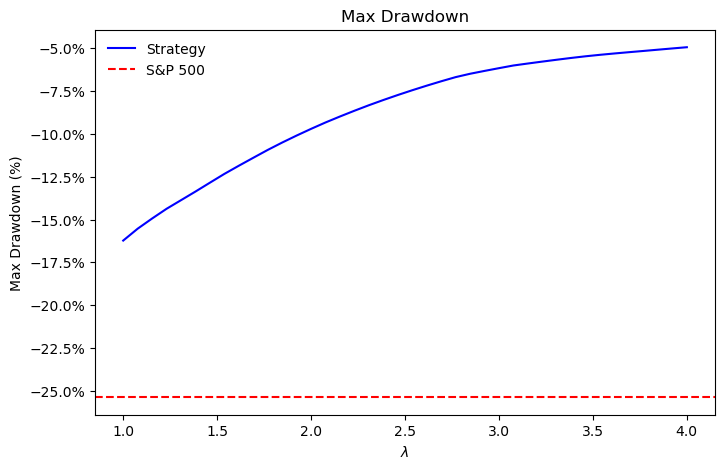

In [31]:
plt.figure(figsize=(8,5))

sns.lineplot(x=lambda_vector, y=test_max_drawdown, color='b', label='Strategy')
# sns.lineplot(x=lambda_vector, y=sp500_risk, color='r', label='sp500')
plt.axhline(y=sp500_max_drawdown[0], color='r', linestyle='--', label='S&P 500')
plt.title(r'Max Drawdown')
plt.xlabel(r'$\lambda$')
plt.ylabel('Max Drawdown (%)')
plt.legend(framealpha=0.0)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # The argument 1 means the data is between 0 and 1

plt.savefig('maxdrawdown_lambda_plot_neformat.png', format='png', dpi=700, transparent=True)
# plt.savefig('maxdrawdown_lambda_plot.pdf', format='pdf', dpi=200)
plt.show()

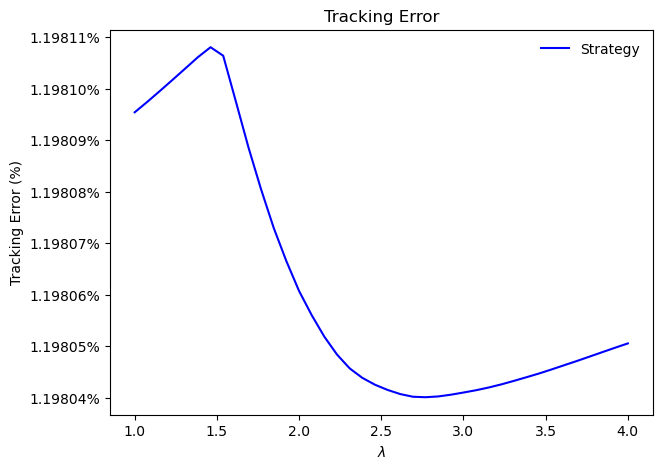

In [138]:
plt.figure(figsize=(7,5))

sns.lineplot(x=lambda_vector, y=test_tracking_error, color='b', marker='o', label='Strategy')
# sns.lineplot(x=lambda_vector, y=sp500_risk, color='r', label='sp500')
# plt.axhline(y=sp500_max_drawdown[0], color='r', linestyle='--', label='S&P 500')
plt.title('Tracking Error')
plt.xlabel(r'$\lambda$')
plt.ylabel('Tracking Error (%)')
plt.legend(framealpha=0.0)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # The argument 1 means the data is between 0 and 1

# plt.savefig('trackingerror_lambda_plot.png', format='png', dpi=700, transparent=True)
# plt.savefig('trackingerror_lambda_plot.pdf', format='pdf', dpi=200)
plt.show()

### Weights distribution

<Axes: >

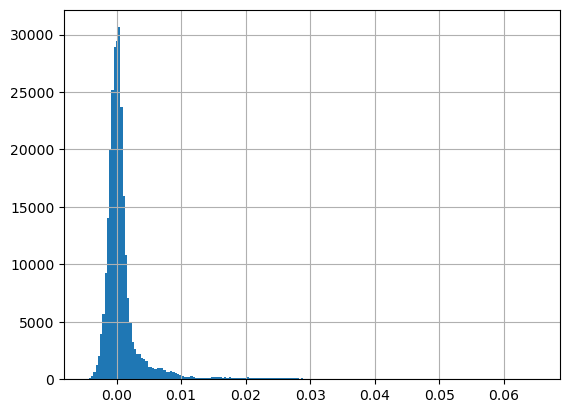

In [51]:
# we ignore zero weights as they come from the series initizalization
non_zero_index = test_support.perturbed_weights != 0
test_support.loc[non_zero_index, 'perturbed_weights'].hist(bins=200)

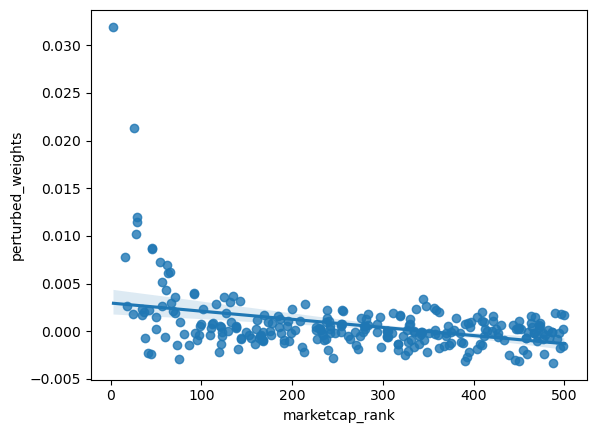

CORRELATIONS
                   marketcap_rank  perturbed_weights
marketcap_rank           1.000000          -0.400567
perturbed_weights       -0.400567           1.000000


,marketcap_ratio,perturbed_weights
marketcap_ratio,1.000000,0.858896
perturbed_weights,0.858896,1.000000


In [52]:
# compute correlations 
non_zero_index = test_support.perturbed_weights != 0

sns.regplot(data=test_support.loc[non_zero_index].sample(frac=0.001), x='marketcap_rank', y='perturbed_weights')
plt.show()

print('CORRELATIONS')
print(test_support.loc[non_zero_index,['marketcap_rank','perturbed_weights']].corr())
test_support.loc[non_zero_index,['marketcap_ratio','perturbed_weights']].corr()

In [22]:
"""
we group by marketcap_rank to evaluate the strategy allocation
"""
# supp = train_support[train_index_df].reset_index(drop=True)
# supp = train_support[validation_index_df].reset_index(drop=True)
supp = test_support

# Step 1: Create bins for marketcap_rank
incremento = max(N // 10, 1)
bins = range(1, N+incremento, incremento)
labels = [f'{i}-{i+incremento-1}' for i in bins[:-1]]

# Step 2: Bin the marketcap_rank and compute mean prediction for each bin
supp['rank_group'] = pd.cut(supp['marketcap_rank'], bins=bins, labels=labels, right=False)

# Step 3: Compute statistics for each bin
grouped = supp.groupby('rank_group')['perturbed_weights']
mean_prediction = grouped.mean() * incremento
std_prediction = grouped.std()
mean_abs_prediction = grouped.apply(lambda x: x.abs().mean()) * incremento
std_abs_prediction = grouped.apply(lambda x: x.abs().std())
mean_sp500 = supp.groupby('rank_group')['marketcap_ratio'].mean() * incremento

# Combine results into a DataFrame for easy plotting
grouped_df = pd.DataFrame({
    'mean': mean_prediction,
    # 'std': std_prediction,
    'mean_abs': mean_abs_prediction,
    # 'std_abs': std_abs_prediction
    'mean_sp500': mean_sp500
}).reset_index(drop=False)

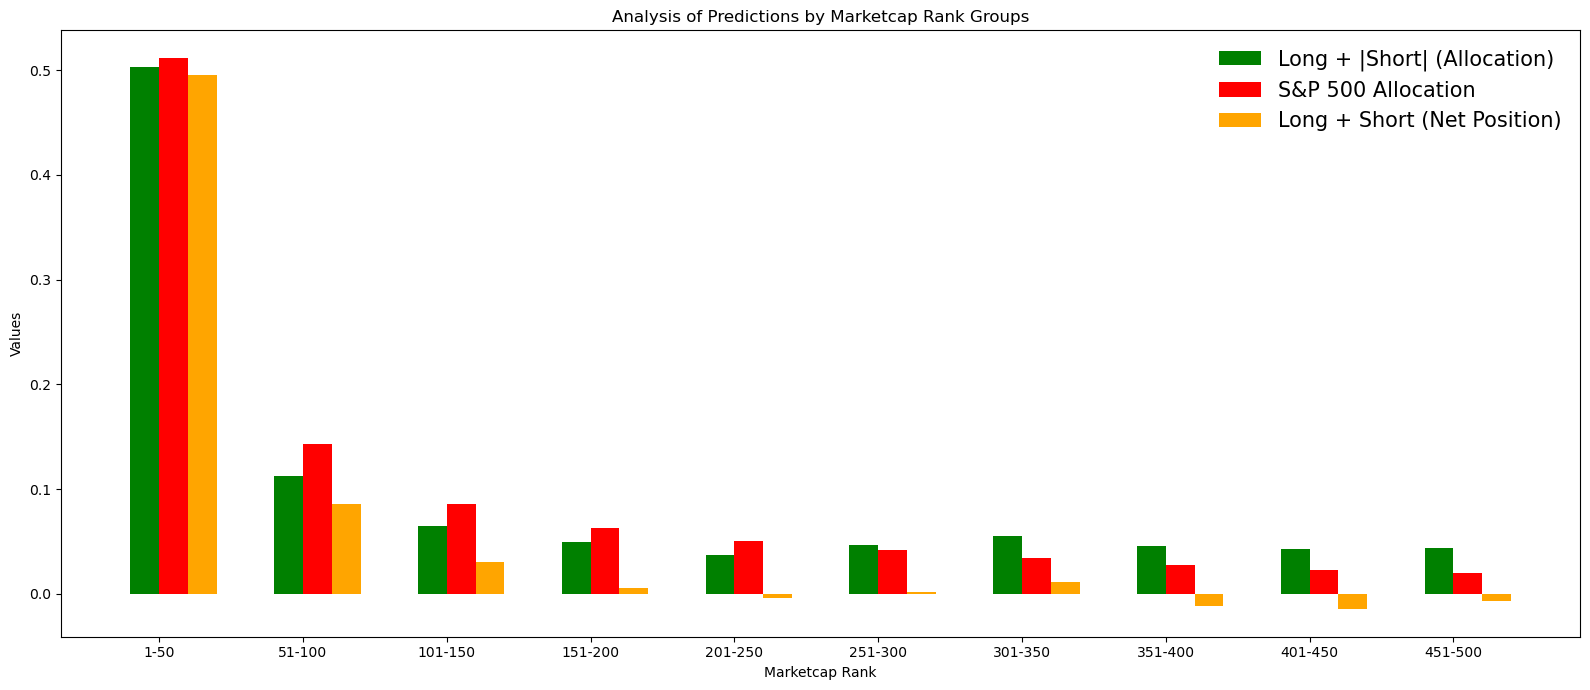

In [29]:
# we plot a bar chart of the generated allocations against the marketcap_rank group
 
# Step 4: Create the bar chart
x = np.arange(len(grouped_df['rank_group']))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 7))

# bars2 = ax.bar(x - 0.5 * width, grouped_df['std'], width, label='Std', color='orange')
bars3 = ax.bar(x - 0.5 * width, grouped_df['mean_abs'], width, label='Long + |Short| (Allocation)', color='green')
# bars4 = ax.bar(x + 1.5 * width, grouped_df['std_abs'], width, label='Std (abs. value)', color='red')
bars5 = ax.bar(x + 0.5 * width, grouped_df['mean_sp500'], width, label='S&P 500 Allocation', color='red')
bars1 = ax.bar(x + 1.5 * width, grouped_df['mean'], width, label='Long + Short (Net Position)', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Marketcap Rank')
ax.set_ylabel('Values')
ax.set_title('Analysis of Predictions by Marketcap Rank Groups')
ax.set_xticks(x)
ax.set_xticklabels(grouped_df['rank_group'], rotation=0)
ax.legend(framealpha=0.0, prop={'size': 15})

# Show the plot
plt.tight_layout()
# plt.savefig('netpositions_bars_200dpi_larger.pdf', format='pdf', dpi=200, transparent=True)
plt.savefig('3bars_bigger_legend.png', format='png', dpi=700, transparent=True)
plt.show()